In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
from tqdm import tqdm

In [2]:
class finite_differences():
    def __init__(self,m,n,dx,dy,A=None):
        self.A = A
        self.m = m
        self.n = n
        self.dx = dx
        self.dy = dy
    def grad(self,v):
        v = v.reshape(self.m,self.n)
        return np.array(np.gradient(v,self.dx,self.dy,axis=(0,1),edge_order=2))[::-1]
    def div(self,v):
        v = v.reshape(2,self.m,self.n)
        return np.array(np.gradient(v[0],self.dx,axis=(1),edge_order=2))+np.array(np.gradient(v[1],self.dy,axis=(0),edge_order=2))
    def divGrad(self,v):
        v = v.reshape(self.m,self.n)
        return self.div(self.grad(v))
    def Agrad(self,v):
        assert (self.A is not None)
        v = v.reshape(self.m,self.n)
        mult = lambda A,v: np.einsum('ijkl,jkl->ikl',A,v)
        return mult(self.A,self.grad(v))
    def divAgrad(self,v):
        assert (self.A is not None)
        v = v.reshape(self.m,self.n)
        mult = lambda A,v: np.einsum('ijkl,jkl->ikl',A,v)
        return self.div(mult(self.A,self.grad(v)))

In [3]:
def genLam(theta,shape,alpha=1,beta=.5):
    lamMinus=np.power(theta/alpha+(np.ones(shape)-theta)/beta,-1)
    lamPlus=alpha*theta+beta*(np.ones(shape)-theta)
    return lamMinus,lamPlus

def lam_theta(theta,shape,alpha=1,beta=.5):
  n,m=shape
  lamPlus_theta=-np.power((1/alpha-1/beta)*(theta/alpha+(np.ones(n,m)-theta)/beta),-2)
  lamMinus_theta=alpha*theta+beta*(np.ones(n,m)-theta)

def genA(theta,phi,shape,alpha=1,beta=.1):
    A = np.zeros(shape+[2,2])
    lamPlus,lamMinus=genLam(theta,shape,alpha,beta)
    #BLOCK A
    for i in range(shape[0]):
      for j in range(shape[1]):
        A1=lamPlus[i,j]*np.cos(phi[i,j])**2+lamMinus[i,j]*np.sin(phi[i,j])**2
        A2=(lamPlus[i,j]+lamMinus[i,j])*np.sin(phi[i,j])*np.cos(phi[i,j])
        A3=lamPlus[i,j]*np.sin(phi[i,j])**2+lamMinus[i,j]*np.cos(phi[i,j])**2
        A[i,j]=np.array([[A1,A2],[A2,A3]])
    return A

def A_theta(thetaK,phiK,alpha=1,beta=.1):
  lamPlus_theta=-(1/alpha-1/beta)*((thetaK/alpha+(1-thetaK)/beta)**(-2))
  lamMinus_theta=alpha-beta

  A1=lamPlus_theta*np.cos(phiK)**2+lamMinus_theta*np.sin(phiK)**2
  A2=(lamPlus_theta+lamMinus_theta)*np.sin(phiK)*np.cos(phiK)
  A3=lamPlus_theta*np.sin(phiK)**2+lamMinus_theta*np.cos(phiK)**2
  
  A_theta=np.array([[A1,A2],[A2,A3]])
  return A_theta

def A_phi(thetaK,phiK,alpha=1,beta=.1):
  lamPlus=np.power(thetaK/alpha+(1-thetaK)/beta,-1)
  lamMinus=alpha*thetaK-beta*(1-thetaK)

  A1=(-lamPlus+lamMinus)*2*np.sin(phiK)*np.cos(phiK)
  A2=(-lamPlus+lamMinus)*(np.cos(phiK)**2-np.sin(phiK)**2)
  A3=(lamPlus-lamMinus)*2*np.sin(phiK)*np.cos(phiK)
  
  A_phi=np.array([[A1,A2],[A2,A3]])
  return A_phi

In [4]:
class heatLens():
    def __init__(self,x,y,f,gamma0,options={}):
        #DOMAIN
        self.m=len(x)
        self.n=len(y)
        self.dx = 1/(m+1)
        self.dy = 1/(n+1)
        self.domain_len = self.m*self.n
        self.domain_shape = (self.m,self.n)
        self.xx, self.yy = np.meshgrid(x,y)
        self.zeros = np.zeros(self.domain_shape)
        self.ones = np.ones(self.domain_shape)
        self.interior = np.ones(self.domain_shape); self.interior[0,:]=np.zeros(m);self.interior[-1,:]=np.zeros(m);self.interior[:,0]=np.zeros(n);self.interior[:,-1]=np.zeros(n)
        #OPTIONS
        self.options=options
        self.check_options()
        #FUNCTION DATA
        self.f=f
        self.neumann_bcs = self.options['neumann_bcs']
        self.dirichlet_bcs = self.options['dirichlet_bcs']
        self.neumann_loc = self.options['neumann_loc']
        self.dirichlet_loc = self.options['dirichlet_loc']
        #INITIALIZE
        self.theta=np.zeros(self.domain_shape)
        self.phi=np.zeros(self.domain_shape)
        self.gamma0 = gamma0
        self.lv=self.options['lv']
        #
        self.grad = lambda v:  np.array(np.gradient(v,self.dx,self.dy,axis=(0,1),edge_order=2))
        self.div = lambda v : np.array(np.gradient(v[0],self.dx,axis=(0),edge_order=2))+np.array(np.gradient(v[1],self.dy,axis=(1),edge_order=2))
        self.fd = finite_differences(m,n,dx,dy)
        self.contract = lambda a,b,c : np.einsum('ijk,ijk->jk',b,
                        np.einsum('ijkl,jkl->ikl',a,c,order='F'),order='F')

    def iterate(self,k):
        for _ in tqdm(range(k)):
            self._iter()

    def _iter(self):
        #INITIALIZE
        alpha=self.options['alpha']
        beta=self.options['beta']
        self.lv = .9*self.lv
        tk=self.options['tk']
        #COEFFICIENTS
        A=genA(self.theta,self.phi,[self.n,self.m],alpha=alpha,beta=beta)
        self.fd.A = A.T
        #PRIMAL SOLUTION VIA RESIDUAL
        primal = lambda v : (self.interior*(self.fd.divAgrad(v))
                                +self.dirichlet_loc*(v.reshape(domain_shape)-self.dirichlet_bcs)
                                +self.neumann_loc[0]*(self.fd.grad(v)[0]-self.neumann_bcs[0]) #D/DN = D/DX BCs
                                +self.neumann_loc[1]*(self.fd.grad(v)[1]-self.neumann_bcs[1]) #D/DN = D/DY BCs
                                ).reshape(self.domain_len)
        u = least_squares(primal,np.zeros(self.domain_len),xtol=self.dx**2).x
        Du = self.fd.grad(u)       
        #ADJOINT SOLUTION VIA RESIDUAL
        adjoint = lambda v : (self.interior*(self.fd.divAgrad(v))
                                +self.dirichlet_loc*(self.fd.grad(v)[1]-self.dirichlet_bcs)
                                +self.fd.grad(v)[0,:,-1]#D/DN = D/DX BCs
                                +self.fd.grad(v)[1,0,:]#D/DN = D/DX BCs
                                +self.fd.grad(v)[1,-1,:]#D/DN = D/DX BCs
                                # +self.neumann_loc[1]*(self.fd.grad(v)[1]-self.neumann_bcs[1]) #D/DN = D/DY BCs
                                ).reshape(self.domain_len)
        p = least_squares(adjoint,np.zeros(self.domain_len),xtol=self.dx**2).x
        Dp = self.fd.grad(p)
        for i in range(self.m):
            for j in range(self.n):
                A_t=A_theta(self.theta[i,j],self.phi[i,j],alpha=alpha,beta=beta)
                rhs=self.theta[i,j]-tk*(self.lv*A_t@Du[:,i,j]@Dp[:,i,j])
                self.theta[i,j]=max([0,min([1,rhs])])
        for i in range(self.m):
            for j in range(self.n):
                A_p=A_phi(self.theta[i,j],self.phi[i,j],alpha=alpha,beta=beta)
                self.phi[i,j]=self.phi[i,j]*tk*(A_p@Du[:,i,j]@Dp[:,i,j])
        # #THETA UPDATE
        # A_t=A_theta(self.theta,self.phi,alpha=alpha,beta=beta)
        # rhs=self.theta-tk*lv*self.contract(A_t,Du,Dp)
        # self.theta=np.maximum(self.zeros,np.minimum(self.ones,rhs))
        # #PHI UPDATE
        # A_p=A_phi(self.theta,self.phi,alpha=alpha,beta=beta)
        # self.phi = self.phi*tk*self.contract(A_p,Du,Dp)
        #SOLUTION DATA
        self.ADu=self.fd.Agrad(u)
        self.sol=self.fd.divAgrad(u)

    def check_options(self):
        assert ('neumann_loc' in self.options) and ('dirichlet_loc' in self.options), 'No boundary conditions provided.'
        assert ('neumann_bcs' in self.options) or ('dirichlet_bcs' in self.options), 'No boundary conditions provided.'
        if not('neumann_bcs' in self.options):
            self.options['neumann_bcs']=np.zeros(self.domain_shape)
        if not('dirichlet_bcs' in self.options):
            self.options['dirichlet_bcs']=np.zeros(self.domain_shape)
        if not('alpha' in self.options):
            self.options['alpha']=.01
        if not('beta' in self.options):
            self.options['beta']=1
        if not('tk' in self.options):
            self.options['tk']=.001
        if not('lv' in self.options):
            self.options['lv']=1

In [5]:
#GRID
L = 2
n,m=40,40
y=np.linspace(-L/2,L/2,n)
x=np.linspace(-L/2,L/2,m)

# Initial Distribution
rho = np.zeros((n,m))
rho[-1,:] = np.ones(n)
gamma0 = np.zeros((n,m)); gamma0[0,m//4:3*m//4]=np.ones(m//2)

n=len(x)
m=len(y)
dx = L/(n+1)
dy = L/(m+1)
domain_len = n*m
domain_shape = (n,m)
xx,yy=np.meshgrid(x,y)
theta=np.zeros(domain_len)
phi=np.zeros(domain_len)

In [6]:
neumann_bcs = np.zeros([2]+list(domain_shape))
neumann_bcs[1,-1,:] = -np.ones(m)
neumann_loc = np.zeros([2]+list(domain_shape))
neumann_loc[0,:,-1] = np.ones(n)
neumann_loc[0,:,0] = np.ones(n)
neumann_loc[1,-1,:] = np.ones(n)
dirichlet_loc = np.zeros(domain_shape)
dirichlet_loc[0,:] = np.ones(n)
dirichlet_bcs = np.zeros(domain_shape); dirichlet_bcs[0,3*n//8:5*n//8]=np.ones(n//4)
options={'lv':100,'neumann_bcs':neumann_bcs,'neumann_loc':neumann_loc,'dirichlet_loc':dirichlet_loc,'dirichlet_bcs':dirichlet_bcs}
prob = heatLens(x,y,rho,dirichlet_bcs,options)

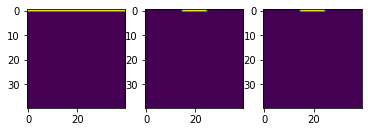

In [7]:
plt.subplot(131)
plt.imshow(prob.dirichlet_loc)
plt.subplot(132)
plt.imshow(prob.dirichlet_bcs)
plt.subplot(133)
plt.imshow(prob.gamma0)

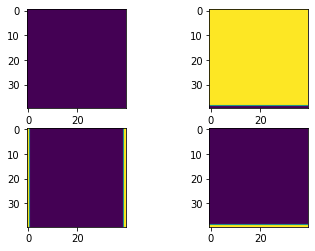

In [8]:
plt.subplot(221)
plt.imshow(prob.neumann_bcs[0])
plt.subplot(222)
plt.imshow(prob.neumann_bcs[1])
plt.subplot(223)
plt.imshow(prob.neumann_loc[0])
plt.subplot(224)
plt.imshow(prob.neumann_loc[1])

In [9]:
print(prob.options['alpha'],prob.options['beta'])

0.01 1


In [10]:
prob.iterate(5)

100%|██████████| 5/5 [04:04<00:00, 48.87s/it]


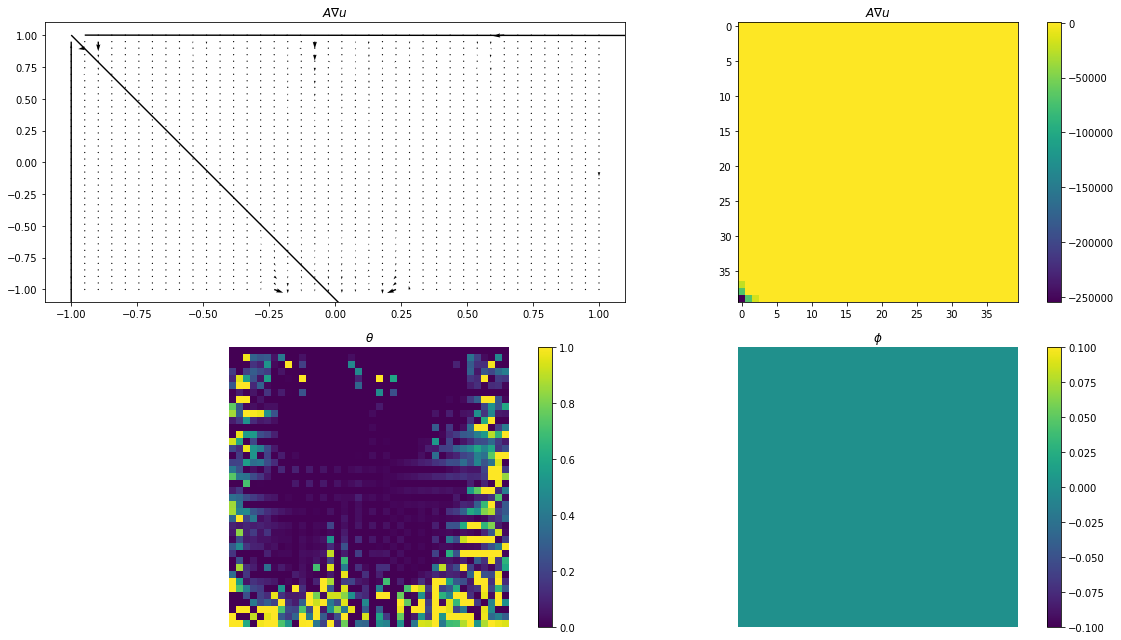

In [11]:
plt.figure(figsize=(16,9),tight_layout=True)
plt.subplot(221)
plt.quiver(prob.xx,prob.yy,prob.ADu[0],prob.ADu[1])
plt.title('$A\\nabla u$')
plt.subplot(222)
plt.imshow(prob.sol)
plt.colorbar()
plt.title('$A\\nabla u$')
plt.subplot(223)
plt.imshow(prob.theta.reshape(prob.domain_shape))
plt.colorbar()
plt.title('$\\theta$')
plt.axis('off')
plt.subplot(224)
plt.imshow(prob.phi.reshape(prob.domain_shape))
plt.colorbar()
plt.title('$\\phi$')
plt.axis('off')
plt.show()